In [123]:
from pyspatialml import Raster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily
import geopandas
from scipy.interpolate import griddata
import rasterio
from copy import deepcopy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import shap
import time
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
import random

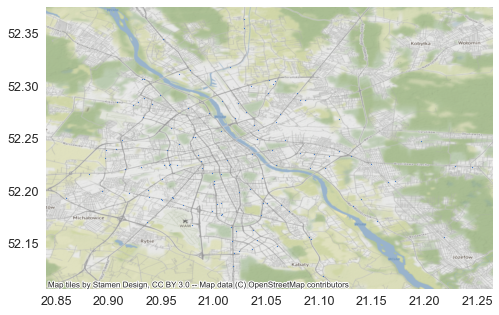

In [108]:
pop_df_warsaw = pd.read_csv("pop_df_warsaw.csv")
df = pd.read_csv("dane.csv")
pop_df_warsaw = geopandas.GeoDataFrame(pop_df_warsaw, geometry=geopandas.points_from_xy(pop_df_warsaw.SHAPE_Leng, pop_df_warsaw.SHAPE_Area), crs='epsg:3035')
stacje = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y), crs='epsg:4326')
ax = stacje.plot(markersize=1)
contextily.add_basemap(ax, crs=stacje.crs.to_string())
plt.show()

In [109]:
pop_grid = geopandas.read_file(r'/Users/alubis/Desktop/OneDrive/mag/PD_STAT_GRID_CELL_2011.shp')
pop_grid = pop_grid.to_crs(epsg=4326)

districts = geopandas.read_file(r'/Users/alubis/Desktop/OneDrive/mag/dzielnice_Warszawy')
districts = districts.to_crs(epsg=4326)
combined = geopandas.overlay(pop_grid, districts, how='intersection')
joined = geopandas.sjoin(stacje, combined, op='within')

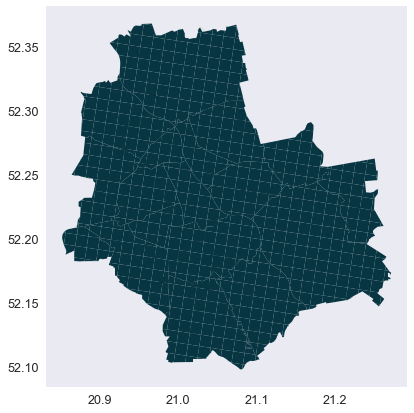

In [110]:
ax = joined.plot(column='wielkosc ruchu')
combined.plot(ax=ax)
plt.show()

In [127]:
dane = pd.read_csv("dane.csv")

In [128]:
#bootstrap
dane_boot = resample(dane, replace=True, n_samples=1000, random_state=1)

In [129]:
y = dane.N
dane= dane[["cena", "x", "y", "liczba gwiazdek", "min_odl_trunk", 'max_odl_trunk', 'avg_odl_trunk',
       'min_odl_primary', 'max_odl_primary', 'avg_odl_primary',
       'palac_kultury', 'min_odl_stacji', 'max_odl_stacji',
       'avg_odl_stacji', 'ile_stacji_r5', 'ile_stacji_r10']]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(dane, y, test_size=0.2)

In [131]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2)))) 
    time.sleep(3)
def plot_f_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = X_train.columns
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

Root mean squared test error = 828.3813505609094


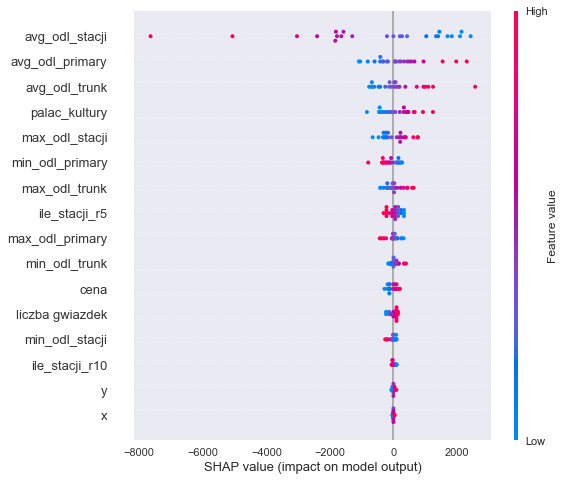

In [132]:
from sklearn import linear_model
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

print_accuracy(lin_regr.predict)
ex = shap.KernelExplainer(lin_regr.predict, X_train)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Root mean squared test error = 983.6797070496426


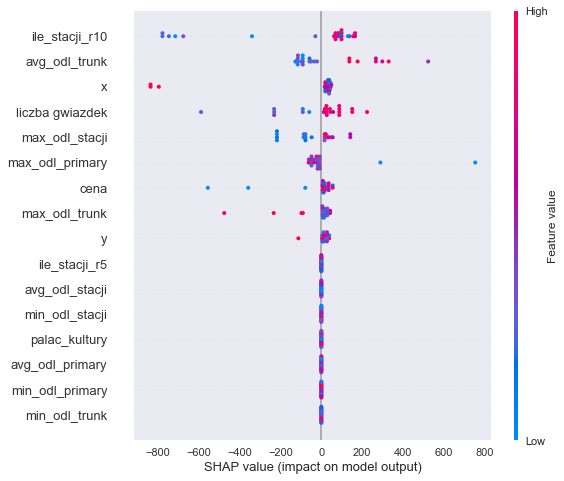

In [133]:
from sklearn import tree
dtree = tree.DecisionTreeRegressor(min_samples_split=20)
dtree.fit(X_train, y_train)
print_accuracy(dtree.predict)

# explain all the predictions in the test set
ex = shap.TreeExplainer(dtree)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

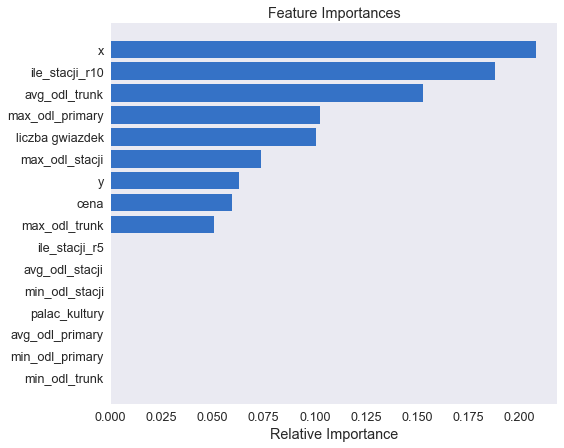

In [134]:
plot_f_importance(dtree)

Root mean squared test error = 870.5226030210737


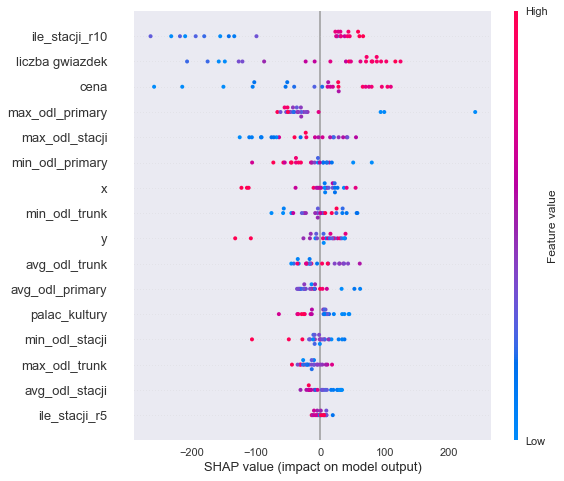

In [135]:
from sklearn.ensemble import RandomForestRegressor
rforest = RandomForestRegressor(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)
print_accuracy(rforest.predict)

# explain all the predictions in the test set
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

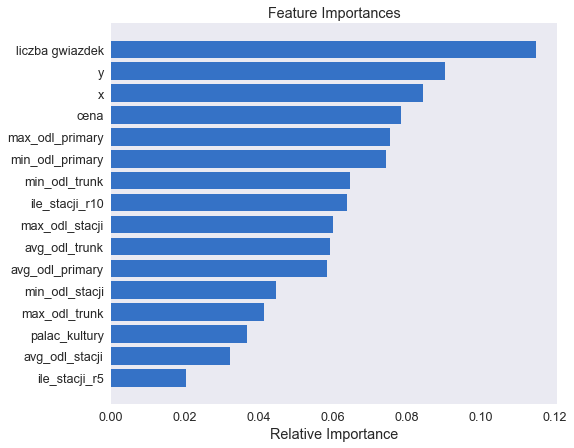

In [136]:
plot_f_importance(rforest)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Root mean squared test error = 877.7137330598123


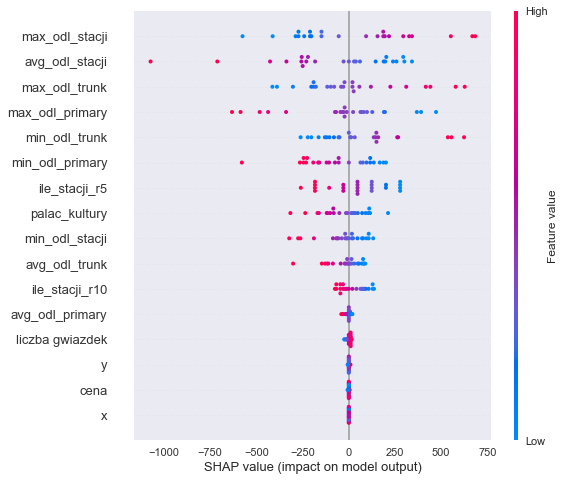

In [137]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)
print_accuracy(nn.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(nn.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)